In [4]:
#from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile
import soundfile


#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
#drive.mount('/content/drive')

In [5]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import time
import torch.optim as optim


In [66]:
timeseries_length = 461


In [361]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate,hop_length=512,n_fft=2048).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=sample_rate, hop_length=512,n_fft=2048).T,axis=0) ###
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T ,axis = 0)
    return mfc_coefficients



def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs, frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag



def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        #chromagram = feature_chromagram(waveform, sample_rate)
        #melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, 1024)

        # my added features
        #######
        #y = waveform
        #sr = sample_rate
        #stft_=np.abs(librosa.stft(waveform))

        #cent = np.mean( librosa.feature.spectral_centroid(y=y, sr=sr,hop_length=512,n_fft=2048).T, axis=0)
        #contrast = np.mean( librosa.feature.spectral_contrast(S=stft_, sr=sr,hop_length=512,n_fft=2048).T, axis=0)
        #tonnetz = np.mean( librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sample_rate ,hop_length=512).T,axis=0)#
        #rms = np.mean( librosa.feature.rms(y=y,frame_length=2048 ,hop_length=512).T, axis=0)
        #spec_bw = np.mean( librosa.feature.spectral_bandwidth(y=y, sr=sr ,n_fft=2048, hop_length=512).T, axis=0)
        #rolloff = np.mean( librosa.feature.spectral_rolloff(y=y, sr=sr ,n_fft=2048, hop_length=512).T, axis=0)
        #zcr = np.mean( librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512).T, axis=0) 
        #######

        #feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        #feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients , cent, contrast, rms, spec_bw, rolloff, zcr))
        #feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients , cent, contrast, rms, spec_bw, rolloff, zcr))
        
        return mfc_coefficients

In [362]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
    
    
    for file in tqdm(files):
        file = file.replace("\\", "/")
        fileID = file.split("/")[-1]
        #print(fileID)
        yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        label = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
        if onlySingleDigit and yi>9:
            continue
        else:
            fs = None # if None, fs would be 22050
            x, fs = librosa.load(file,sr=fs)
            if scale_audio: x = x/np.max(np.abs(x))
            f0, voiced_flag = getPitch(x,fs,winLen=0.02)

            power = np.sum(x**2)/len(x)
            pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
            pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
            voiced_fr = np.mean(voiced_flag)

            #added 
            features = get_features(file)

            #xi = [power,pitch_mean,pitch_std,voiced_fr]

            #xi = np.hstack((power,pitch_mean,pitch_std,voiced_fr,features))
           
            data["mfcc"].append(features)
            data["labels"].append(label) 
            
            X.append(features)
            y.append(label)
    return np.array(X),np.array(y) , data

In [363]:
labels = pd.read_csv('./Data/MLEnd/trainingMLEnd.csv')
labels


,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


In [397]:
files = glob.glob("./Data/MLEnd/training/Training/*.wav" )


X,y,data = getXy(files[:20000],labels_file=labels,scale_audio=True, onlySingleDigit=True)

#a,b = getXy(files[:1000],labels_file=labels,scale_audio=True, onlySingleDigit=True)


100%|██████████| 20000/20000 [46:42<00:00,  7.14it/s]  


In [416]:
# convert lists to numpy arrays
a = np.array(data["mfcc"])
b = np.array(data["labels"])

print(X.shape)
print(y.shape)

print("Data succesfully loaded!")

(6533, 40)
(6533,)
Data succesfully loaded!


In [399]:
with open('X.npy', 'wb') as f:
    np.save(f, X)

In [400]:
with open('y.npy', 'wb') as f:
    np.save(f, y)

In [401]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [402]:
#data["mfcc"]

In [403]:
#X[0].shape

In [404]:
mfc_coefficients_df = pd.DataFrame(X) # make it pretty for display
#print(mfc_coefficients.shape)
mfc_coefficients_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-534.181213,62.225002,20.557640,22.183336,25.795078,12.347731,7.769064,8.587548,4.326677,3.105296,...,-1.582524,-0.973201,-0.137218,0.148732,0.328271,0.304176,0.059946,-0.187141,-0.846380,-1.622461
1,-246.419617,94.660927,12.061924,16.406849,-2.200624,9.724667,-1.533366,19.008320,-7.362433,12.091580,...,-0.319912,-0.273057,-3.595602,0.327480,-0.886008,2.233625,1.391799,1.091676,-1.610425,-5.212348
2,-413.726410,75.193619,47.802803,29.036753,13.340115,18.621609,14.480982,11.311208,3.081939,5.776513,...,-1.096239,-1.275365,0.800221,1.834801,1.830003,0.633408,-2.566371,-0.886144,-0.074147,-0.190782
3,-291.471436,76.496452,47.417202,34.920078,4.092849,7.402806,20.403294,11.985517,0.714628,8.623523,...,-2.241488,-2.002609,-1.282523,0.742153,1.323593,0.409754,-1.953654,-1.628271,-1.306299,-1.433958
4,-289.195099,72.151146,13.590457,21.889238,14.882520,2.293742,7.377840,6.759739,1.081694,10.797849,...,0.439510,-0.121425,2.134580,1.626710,-0.893704,0.453355,0.299412,-1.900960,-0.393362,0.400126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6528,-332.642700,87.140694,8.936095,-0.632560,4.977781,-0.484734,12.728754,20.972776,8.507303,6.559069,...,-1.365314,-0.959850,-1.355088,-1.054486,-0.540814,-1.249480,-1.449300,-0.986246,-1.187088,-1.121170
6529,-255.098343,143.863831,-36.007374,10.098045,23.624268,-24.339680,-0.818038,4.930203,-12.858186,9.089379,...,3.057713,-3.059985,-3.298787,-0.106133,-3.199076,0.498992,2.370037,-2.395240,2.316676,4.446616
6530,-437.870636,139.197449,12.033515,27.491802,28.406446,0.454138,11.518676,-1.129121,-16.293184,8.486189,...,1.552512,-2.839352,-2.465420,-0.133318,-2.293819,0.299109,1.403964,-2.218910,-0.478350,0.085876
6531,-406.779419,33.638851,-2.647163,24.836136,-7.464918,22.501417,-5.098368,19.601625,-5.356905,17.687160,...,1.613541,2.373388,0.608841,2.898928,2.554806,1.282406,1.644913,3.100463,1.500495,0.579609


In [405]:
#X[7][4].shape

In [406]:
#a.shape[1]

In [407]:
#a.shape[2]

In [408]:
#import math
#hop_length = 512

#timeseries_length_list = []
#for file in files[:20000]:
#    #print("Loading " + str(file))
#    y, sr = librosa.load(file)
#    timeseries_length_list.append(math.ceil(len(y) / hop_length))
    
#max(timeseries_length_list)

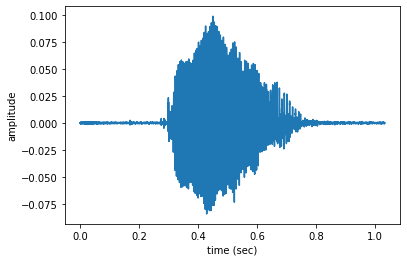

In [409]:
n=10
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=22050)

t = np.arange(len(x))/fs

plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

In [410]:
print(type(x))
print(x.shape)

<class 'numpy.ndarray'>
(22784,)


In [411]:
#n=0
x, fs = librosa.load(files[10000],sr=10024)
print('This audio signal has', len(x)/512, 'samples')

This audio signal has 22.27734375 samples


In [332]:
print(type(x))
print(x.shape)
print(x)

<class 'numpy.ndarray'>
(892,)
[ 3.29750992e-06 -5.17201261e-05 -6.77703647e-05 -4.36939736e-05
 -4.10199427e-05 -3.48738395e-05 -1.94265122e-05 -3.96675605e-05
  3.09599673e-05 -2.46513791e-05 -7.46270962e-06  6.11778887e-05
 -3.94798990e-05  3.91688009e-05 -1.38525602e-05  1.98578691e-05
 -4.71730345e-05  1.95498978e-05 -1.86201778e-05 -7.09857268e-05
  9.11193420e-05 -1.87713638e-04  9.79933611e-05 -7.99932895e-05
 -1.29272608e-04  1.12584057e-04 -1.66803919e-04  6.64644103e-05
 -5.60729786e-05 -8.45314389e-06  1.25766610e-06 -9.55104842e-05
 -2.18514060e-06 -9.55488649e-05 -6.22637745e-05 -8.64547401e-05
  2.04081662e-05 -9.33234114e-05  3.38512873e-05  4.50302396e-05
 -8.90176161e-05  9.40471145e-05 -8.50612632e-05 -4.53881057e-06
 -3.40434817e-05 -5.18090492e-05  2.80167242e-05 -4.87188299e-05
  5.75313206e-05 -1.84668443e-05  3.65513115e-05  2.23452116e-05
  5.71452438e-06  1.98236630e-05  1.09314979e-05 -2.53213625e-06
 -1.82576641e-05  6.60749938e-05 -1.17198026e-04  5.2149065

In [335]:
data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

m =librosa.feature.mfcc(y=x, sr=fs , n_mfcc=40,hop_length=512).T
m 

array([[-1.66617264e+02, -3.58742485e+01, -1.13423462e+02,
         1.83360964e-01, -7.47923279e+01,  1.44164810e+01,
        -3.10679207e+01,  4.12481079e+01,  2.35524826e+01,
         4.34162598e+01, -3.56099167e+01,  2.25454254e+01,
        -1.83605080e+01,  7.26098585e+00, -3.23829041e+01,
        -1.29063034e+01,  1.19893961e+01,  2.03136864e+01,
        -9.97757816e+00, -4.31601095e+00, -9.20925331e+00,
        -1.16092891e-01, -8.47637177e+00,  5.76494122e+00,
         2.15572000e-01,  2.05333023e+01, -1.02934515e+00,
         1.18769455e+00, -4.28602362e+00, -2.04669857e+00,
        -1.10488284e+00, -6.20224476e+00, -2.14317262e-01,
        -7.23816514e-01,  7.04894257e+00, -2.27924776e+00,
        -2.92913485e+00, -3.50767374e+00,  6.56385958e-01,
        -2.63832951e+00],
       [-1.58951675e+02, -4.04888496e+01, -1.11644005e+02,
         1.98681283e+00, -7.45193024e+01,  1.25284319e+01,
        -3.25442123e+01,  4.19790344e+01,  2.26255398e+01,
         4.54487152e+01, -3.26

In [287]:
m.shape

(40,)

In [167]:
data["mfcc"].append(m.tolist())

In [168]:
#m.tolist()

[[-671.5302734375,
  10.528260231018066,
  7.362443923950195,
  3.828178882598877,
  1.1961519718170166,
  -0.12163373827934265,
  -0.3854006230831146,
  -0.04684656858444214,
  0.47191253304481506,
  0.7829121351242065,
  0.6501057744026184,
  0.18549805879592896,
  -0.24051843583583832,
  -0.4214818775653839,
  -0.5765478610992432,
  -1.0531412363052368,
  -1.791550874710083,
  -2.2543041706085205,
  -1.9773926734924316,
  -1.0927824974060059,
  -0.17676043510437012,
  0.3858046233654022,
  0.7478185296058655,
  1.2913801670074463,
  2.121812582015991,
  2.98258113861084,
  3.580685615539551,
  3.8113558292388916,
  3.6418042182922363,
  2.9710545539855957,
  1.782763957977295,
  0.3807980418205261,
  -0.7245474457740784,
  -1.2448545694351196,
  -1.3236138820648193,
  -1.2313377857208252,
  -0.9531269073486328,
  -0.2664594352245331,
  0.7403417825698853,
  1.405277967453003],
 [-669.0040283203125,
  14.556802749633789,
  12.398038864135742,
  9.700790405273438,
  7.306818962097168,

mfc_coefficients=  np.mean(librosa.feature.melspectrogram(y=x, sr=fs, n_mels=128, fmax=fs, hop_length=512,n_fft=2048).T,axis=0) ###

mfc_coefficients_df = pd.DataFrame(mfc_coefficients) # make it pretty for display
print(mfc_coefficients.shape)
mfc_coefficients_df

In [ ]:
#audio_data = concatenate( (audio_data, zeros( (51 - audio_data.shape[0], 36) )))


In [368]:
#data = np.zeros((len(files[:13] ), 190,timeseries_length), dtype=np.float64)
#data.shape

In [ ]:
#if x.shape[0] < 51:
#    audio_data = concatenate( (audio_data, zeros( (51 - audio_data.shape[0], 36) )))
#audio_data

#data = np.zeros( (len(list_of_audiofiles), self.timeseries_length, 33), dtype=np.float64 )

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif#

#X.shape
X_new = SelectKBest(mutual_info_classif, k=190).fit_transform(X, y)
#X_new = SelectKBest(mutual_info_classif, k=150).fit_transform(a, b)

X_new.shape

(337, 190)

In [75]:
print(f'\nAudio samples represented: {X_new.shape[0]}')
print(f'Numerical features extracted per sample: {X_new.shape[1]}')
features_df = pd.DataFrame(X_new) # make it pretty for display
features_df


Audio samples represented: 337
Numerical features extracted per sample: 190


,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
0,0.010129,208.882834,118.829623,0.215278,0.753131,0.766886,0.749057,0.671027,0.634170,0.670543,...,12.066502,13.726420,15.600197,15.085901,15.386061,19.041806,0.009657,2197.995732,4693.939209,0.159003
1,0.035339,157.289085,31.784415,0.293333,0.583537,0.643321,0.677088,0.669812,0.709702,0.740893,...,13.944263,15.772536,16.208509,17.446751,17.795718,27.592407,0.031027,2434.352641,5335.701069,0.155646
2,0.013676,134.964540,4.520547,0.084507,0.677341,0.748570,0.695867,0.597716,0.595714,0.726472,...,12.323731,16.377326,15.793714,20.858538,21.230001,19.016606,0.031680,1446.833328,1627.869907,0.027166
3,0.052517,181.944641,40.719889,0.494253,0.569682,0.537822,0.540425,0.537556,0.533592,0.509157,...,15.977014,20.075173,18.970150,17.982028,19.588298,25.813768,0.078083,1994.697128,3658.686967,0.105957
4,0.027461,109.742686,18.208426,0.120000,0.704168,0.769274,0.750523,0.715473,0.715584,0.750014,...,11.006136,14.597893,15.629837,15.968503,17.372982,28.002703,0.073354,1915.549197,4090.016602,0.118665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,0.069766,169.263786,37.915774,0.654545,0.574586,0.549301,0.550144,0.530207,0.498767,0.489934,...,17.387905,22.698205,17.053378,19.010217,19.918645,26.298124,0.081792,2197.950735,3885.568626,0.046671
333,0.026559,237.843853,28.992245,0.306306,0.607536,0.571724,0.467266,0.450119,0.520315,0.563011,...,18.214393,18.488736,20.327478,20.695527,17.633616,27.010899,0.033097,1308.785867,2248.681641,0.071995
334,0.070466,218.394519,11.606973,0.357143,0.571892,0.471446,0.463473,0.476342,0.409125,0.290854,...,18.132604,16.945738,15.973385,18.100101,16.292020,31.573117,0.093979,3010.964264,7461.447144,0.280055
335,0.027305,105.855202,4.478636,0.406593,0.595436,0.627027,0.647870,0.764208,0.754700,0.590106,...,14.004776,17.261628,14.990729,19.036370,19.929089,28.120640,0.026049,2568.852787,5349.596637,0.126274


In [417]:
intonation_list = np.unique(y)
intonation_list

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

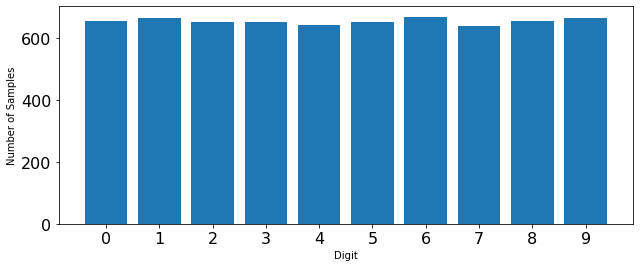

In [418]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
intonation_list, count = np.unique(y, return_counts=True)
plt.bar(x=range(10), height=count)
plt.xticks(ticks=range(10), labels = [intonation for intonation in intonation_list],fontsize=10)
plt.xlabel('Digit')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [22]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
    idx = np.isnan(X).sum(1)>0
    X = X[~idx]
    y = y[~idx]
print(np.sum(np.isnan(X)))

0


In [419]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = X
#features_scaled = a
#features_scaled = X_new
features_scaled = scaler.fit_transform(features_scaled)

#scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
#features_minmax = features
#features_minmax = scaler.fit_transform(features_minmax)

In [420]:
features_scaled_df = pd.DataFrame(features_scaled) # make it pretty for display
features_scaled_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-1.276046,-0.629079,0.219724,0.009917,1.237081,0.010212,0.096062,-0.542718,0.289914,-0.879726,...,-0.537128,-0.091985,0.161685,0.392587,0.488931,0.517021,0.313057,0.204819,-0.166526,-0.619086
1,1.556093,0.388958,-0.146272,-0.394474,-0.890985,-0.213109,-0.897591,0.764551,-1.230814,0.308638,...,-0.011847,0.208874,-1.325766,0.473874,-0.071709,1.495578,0.976641,0.854150,-0.577096,-2.593304
2,-0.090534,-0.222045,1.393445,0.489700,0.290329,0.544355,0.813006,-0.201039,0.127976,-0.526479,...,-0.334820,-0.221828,0.564877,1.159338,1.182290,0.683997,-0.995483,-0.150107,0.248445,0.168250
3,1.112694,-0.181154,1.376834,0.901570,-0.412593,-0.410787,1.445607,-0.116448,-0.180006,-0.149984,...,-0.811275,-0.534332,-0.330911,0.662449,0.948477,0.570566,-0.690202,-0.526930,-0.413670,-0.515421
4,1.135098,-0.317536,-0.080423,-0.010672,0.407573,-0.845760,0.054273,-0.772013,-0.132251,0.137553,...,0.304093,0.274032,1.138784,1.064707,-0.075263,0.592680,0.432369,-0.665390,0.076910,0.493214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6528,0.707488,0.152927,-0.280933,-1.587340,-0.345325,-1.082313,0.625839,1.010989,0.833804,-0.422992,...,-0.446762,-0.086248,-0.362121,-0.154585,0.087669,-0.270946,-0.438912,-0.200935,-0.349610,-0.343406
6529,1.470677,1.933245,-2.217098,-0.836130,1.072069,-3.113265,-0.821182,-1.001526,-1.945799,-0.088379,...,1.393337,-0.988697,-1.198105,0.276685,-1.139668,0.615826,1.464040,-0.916366,1.533187,2.718536
6530,-0.328161,1.786785,-0.147496,0.381543,1.435581,-1.002379,0.496583,-1.761657,-2.392685,-0.168146,...,0.767133,-0.893889,-0.839674,0.264322,-0.721705,0.514451,0.982703,-0.826833,0.031240,0.320396
6531,-0.022162,-1.526287,-0.779939,0.195630,-1.291145,0.874673,-1.278392,0.838980,-0.969899,1.048609,...,0.792522,1.346079,0.482564,1.643257,1.516936,1.013149,1.102753,1.874133,1.094601,0.591918


In [421]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
#X_train, X_val, y_train, y_val = train_test_split(
#    X, 
#    y, 
#    test_size=0.2, 
#    stratify=y
#)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values 
X_train_scaled, X_test_scaled, y_train, y_val = train_test_split(
    features_scaled, 
    y, 
    test_size=0.2, 
    stratify=y
)


## RNN

In [521]:
from torch.utils.data.dataset import Dataset


class CustomDataset(Dataset):
    def __init__(self, data,label ):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.datas = torch.from_numpy(data)
        self.labels = torch.from_numpy(label)
        self.length = len(self.labels)

    def __getitem__(self, index):
        
        a = self.datas[index]
        b = self.labels[index]

        return (a, b)

    def __len__(self):
        return self.length
        




In [522]:
customData = CustomDataset( X,y)

In [523]:
batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(X_train_scaled) / batch_size)
num_epochs = int(num_epochs)


In [524]:
#train_X = torch.from_numpy(X_train_scaled).type(torch.Tensor)
#dev_X = torch.from_numpy(X_test_scaled).type(torch.Tensor)

# Targets is a long tensor of size (N,) which tells the true class of the sample.
#train_Y = torch.from_numpy(y_train).type(torch.LongTensor)
#dev_Y = torch.from_numpy(y_val).type(torch.LongTensor)

In [525]:
# Define data loader
mn_dataset_loader = torch.utils.data.DataLoader(dataset=customData,batch_size=batch_size,shuffle=False)

train_loader = torch.utils.data.DataLoader(dataset=mn_dataset_loader, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mn_dataset_loader, batch_size=batch_size, shuffle=False)

In [526]:
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [527]:
input_dim = 40
hidden_dim = 100
layer_dim = 1
output_dim = 10

In [532]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)


In [533]:
criterion = nn.CrossEntropyLoss()


In [534]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, input_dim)
        # batch_dim = number of samples per batch
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 10
        # out[:, -1, :] --> 100, 10 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [543]:
#mn_dataset_loader = torch.utils.data.DataLoader(dataset = customData,batch_size=batch_size,shuffle=False)
#customData =customData.type(torch.LongTensor)
train_loader = torch.utils.data.DataLoader(dataset = customData, batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset = customData, batch_size=batch_size, shuffle=True)


for data, labels in test_loader:
    print(data)

tensor([[-4.0848e+02,  5.5268e+01,  4.0950e+01,  ...,  2.2020e+00,
          1.4607e+00,  2.2036e+00],
        [-2.6004e+02, -4.0876e+00,  2.1921e+01,  ..., -4.1082e+00,
         -4.5339e+00, -5.5191e+00],
        [-3.7787e+02,  8.9353e+01,  1.2157e+01,  ..., -5.7284e-01,
         -7.9846e-01, -1.1968e+00],
        ...,
        [-4.7574e+02,  1.1067e+02,  3.0663e+01,  ...,  2.9274e+00,
          6.9517e-01,  3.5809e+00],
        [-5.7223e+02,  9.1222e+01,  2.6707e+01,  ..., -2.8003e-01,
         -1.4276e-01, -1.6494e+00],
        [-3.3493e+02,  1.0027e+02, -9.3915e-01,  ...,  3.0288e+00,
          3.8056e+00,  3.8789e-01]])
tensor([[-2.7870e+02,  7.7657e+01,  2.4084e+01,  ..., -3.3389e+00,
         -1.5377e+00, -1.9541e+00],
        [-3.4142e+02,  7.1673e+01,  1.0634e+01,  ...,  1.2933e+00,
          2.3881e+00,  2.5042e+00],
        [-4.9413e+02,  1.6197e+02, -2.4436e+01,  ...,  1.7970e+00,
          7.7013e-02,  2.1555e+00],
        ...,
        [-3.3854e+02,  6.6953e+01,  6.4214e+00

In [544]:
# Number of steps to unroll
seq_dim = 1 

iter = 0

for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(train_loader):
        model.train()
        # Load data as tensors with gradient accumulation abilities
        data = data.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(data)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for data, labels in test_loader:
                # Load data to a Torch tensors with gradient accumulation abilities
                data = data.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(data)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

RuntimeError: expected scalar type Long but found Int


# class definition
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=8, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # setup LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # setup output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        return (
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
        )

    def forward(self, input):
        # lstm step => then ONLY take the sequence's final timetep to pass into the linear/dense layer
        # Note: lstm_out contains outputs for every step of the sequence we are looping over (for BPTT)
        # but we just need the output of the last step of the sequence, aka lstm_out[-1]
        lstm_out, hidden = self.lstm(input)
        logits = self.linear(lstm_out[-1])
        genre_scores = F.log_softmax(logits, dim=1)
        return genre_scores

    def get_accuracy(self, logits, target):
        """ compute accuracy for training round """
        corrects = (
            torch.max(logits, 1)[1].view(target.size()).data == target.data
        ).sum()
        accuracy = 100.0 * corrects / self.batch_size
        return accuracy.item()


batch_size = 35  # num of training examples per minibatch
num_epochs = 400

# Define model
print("Build LSTM RNN model ...")
model = LSTM( input_dim=190, hidden_dim=128, batch_size=batch_size, output_dim=10, num_layers=2 )

loss_function = nn.NLLLoss()  # expects ouputs from LogSoftmax

optimizer = optim.Adam(model.parameters(), lr=0.001)

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("\nTraining on GPU")
else:
    print("\nNo GPU, training on CPU")

# all training data (epoch) / batch_size == num_batches (12)
num_batches = int(train_X.shape[0] / batch_size)
num_dev_batches = int(dev_X.shape[0] / batch_size)

val_loss_list, val_accuracy_list, epoch_list = [], [], []